In [1]:
from quantum_electron import FullModel, QuantumAnalysis, PotentialVisualization
from quantum_electron.utils import r2xy
import numpy as np
from matplotlib import pyplot as plt
from scipy.constants import elementary_charge as qe, epsilon_0 as eps0, electron_mass as me, Boltzmann as kB
import alive_progress


# Construct the potential

In [2]:
# Note that the units of x and y are implicitly assumed as microns
x = np.linspace(-2, 2, 201)
y = np.linspace(-2, 2, 201)

micron = 1e-6

X, Y = np.meshgrid(x, y)
X *= micron
Y *= micron

parabolic_confinement = - (X ** 2 + Y ** 2) / micron ** 2

R = 1.5e-6
# outside the circle there is a guard ring where the dot 
parabolic_confinement[np.sqrt(X**2 + Y**2) > R] = -(R / micron) ** 2
# parabolic_confinement -= -(R / micron) ** 2

# also add the guard ring
guard_ring = np.ones(X.shape)
guard_ring[np.sqrt(X**2 + Y**2) < R] = 0 

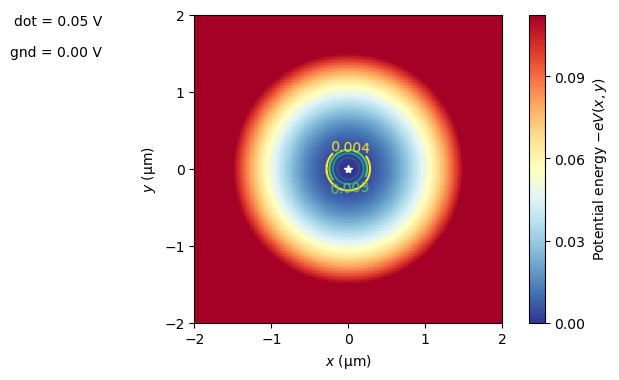

In [3]:
potential_dict = {"dot" : parabolic_confinement, 
                  "gnd" : guard_ring, 
                  "xlist" : x, 
                  "ylist" : y}

# Let's apply these voltages to the corresponding electrodes in potential_dict
voltages = {"dot" : 0.05, 
            "gnd" : 0}

p = PotentialVisualization(potential_dict, voltages)
p.plot_potential_energy(dxdy=(4, 4))

# Minimization with `L-BFGS-B`

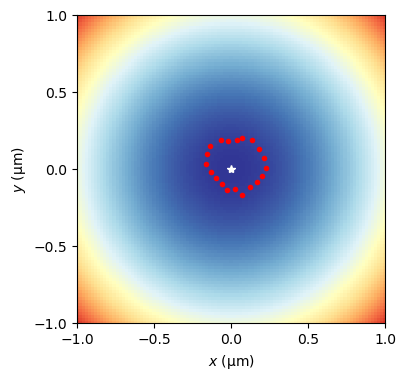

In [16]:
n_electrons = 20

fig, ax = plt.subplots(1, 1, figsize=(4, 4))

fm = FullModel(potential_dict=potential_dict, voltage_dict=voltages, trap_annealing_steps=[1.0]*20)

initial_condition = fm.generate_initial_condition(n_electrons=n_electrons) + 0.05e-6 * np.random.rand(2 * n_electrons)
init_x, init_y = r2xy(initial_condition)

res = fm.get_electron_positions(n_electrons=n_electrons, electron_initial_positions=None)

fm.plot_potential_energy(ax=ax, dxdy=(2, 2), print_voltages=False, plot_contours=False)
# fm.plot_electron_positions(res, ax=ax)

plt.plot(init_x*1e6, init_y*1e6, '.r')

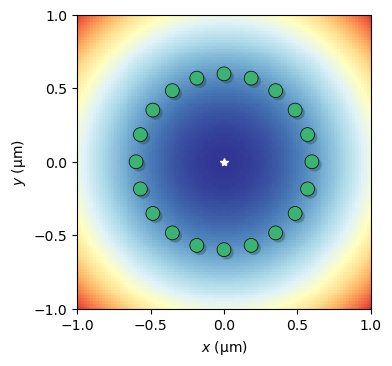

In [17]:
anim = fm.animate_convergence(frame_interval_ms=30)

In [18]:
fm.show_animation(anim)

# Physical gradient descent

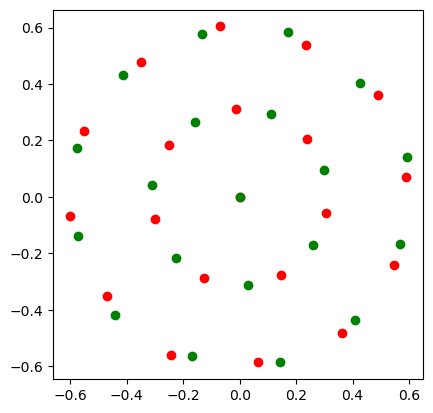

In [19]:
n_timesteps = 5000
dt = 1e-13
gamma = -0.01 * me / dt

r = np.zeros((2 * n_electrons, n_timesteps+2))

r[:, 0] = initial_condition
r[:, 1] = initial_condition

for k in range(2, n_timesteps+2):
    prefactor = 1 / (me / dt ** 2 - gamma / dt)
    F = - qe * fm.grad_total(r[:, k-1])
    r[:, k] = prefactor * (F - r[:, k-1] * (-2 * me / dt ** 2 + gamma / dt) - r[:, k-2] * me / dt ** 2)
    
rx, ry = r2xy(r[:, -1])
final_x, final_y = r2xy(res['x'])

# plt.plot(init_x*1e6, init_y*1e6, 'ob')
plt.plot(rx*1e6, ry*1e6, 'or')
plt.plot(final_x*1e6, final_y*1e6, 'og')
plt.gca().set_aspect('equal')

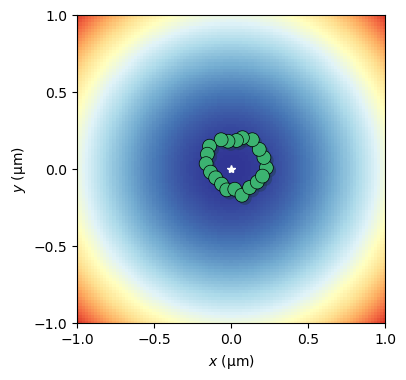

In [20]:
import matplotlib.animation as animation
from matplotlib import patheffects as pe

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
fm.plot_potential_energy(ax=ax, dxdy=(2, 2), print_voltages=False, plot_contours=False)

rx, ry = r2xy(r[:, -1])
pts_data = ax.plot(rx*1e6, ry*1e6, 'ok', mfc='mediumseagreen', mew=0.5, ms=10, path_effects=[pe.SimplePatchShadow(), pe.Normal()])

# Only things in the update function will get updated.
def update(frame):
    rx, ry = r2xy(r[:, frame])
    # Update the electron positions (green dots)
    pts_data[0].set_xdata(rx * 1e6)
    pts_data[0].set_ydata(ry * 1e6)

    return pts_data, 

# The interval is in milliseconds 
anim = animation.FuncAnimation(fig=fig, func=update, frames=np.arange(2, n_timesteps+2, 25), interval=30, repeat=True)

In [21]:
fm.show_animation(anim)

# Sample from the Maxwell-Boltzmann distribution

In [62]:
import scipy
from scipy.constants import Boltzmann as kB

class MaxBoltz2D(scipy.stats.rv_continuous):
    def _pdf(self, v):
        T = 0.5
        sigma = np.sqrt(kB * T / me)
        return v / sigma ** 2 * np.exp(- v ** 2 / (2 * sigma ** 2))
    
sample_v = MaxBoltz2D(a=0, b=4e4, name='velocity')

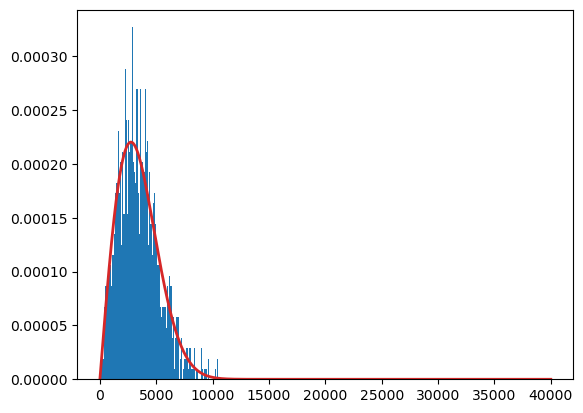

In [63]:
samples = sample_v.rvs(size=1000)
v = np.linspace(0, 4e4, 10000)

plt.hist(samples, bins=100, density=True)
plt.plot(v, sample_v._pdf(v), color='tab:red', lw=2)

|████████████████████████████████████████| 20000/20000 [100%] in 15.2s (1312.08/s)                                      


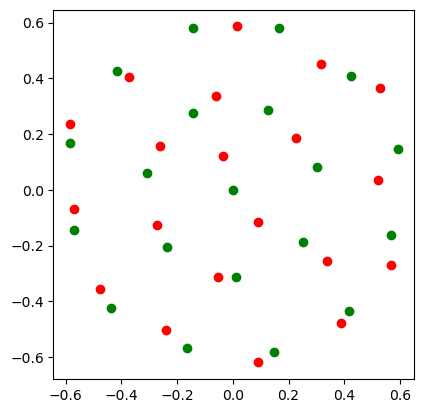

In [64]:
n_timesteps = 20000
dt = 1e-13
gamma = -0.01 * me / dt

r = np.zeros((2 * n_electrons, n_timesteps+2))

# Start with the best solution at T = 0
# perturbation = 0.1*np.random.rand(2 * n_electrons) * 1e-6
r[:, 0] = res['x'] #+ perturbation
r[:, 1] = res['x'] #+ perturbation

with alive_progress.alive_bar(n_timesteps, force_tty=True) as bar:
    for k in range(2, n_timesteps+2):
        prefactor = 1 / (me / dt ** 2 - gamma / dt)
        F = - qe * fm.grad_total(r[:, k-1])
        r[:, k] = prefactor * (F - r[:, k-1] * (-2 * me / dt ** 2 + gamma / dt) - r[:, k-2] * me / dt ** 2)
        
        if not (k%50):
            # Add some temperature
            velocities = sample_v.rvs(size=n_electrons)
            thetas = np.random.uniform(low=0, high=2*np.pi, size=n_electrons)
            perturbation = np.zeros(2 * n_electrons)
            perturbation[::2] = velocities * np.cos(thetas) * dt
            perturbation[1::2] = velocities * np.sin(thetas) * dt
            
            # perturbation = random_sign(2 * n_electrons) * velocities * dt
            r[:, k] = r[:, k-2] + perturbation * 100
            r[:, k-1] = r[:, k-2] + perturbation * 100
            r[:, k-2] = r[:, k-2] + perturbation * 100
    
        bar()
    
rx, ry = r2xy(r[:, -1])
final_x, final_y = r2xy(res['x'])

# plt.plot(init_x*1e6, init_y*1e6, 'ob')
plt.plot(rx*1e6, ry*1e6, 'or')
plt.plot(final_x*1e6, final_y*1e6, 'og')
plt.gca().set_aspect('equal')

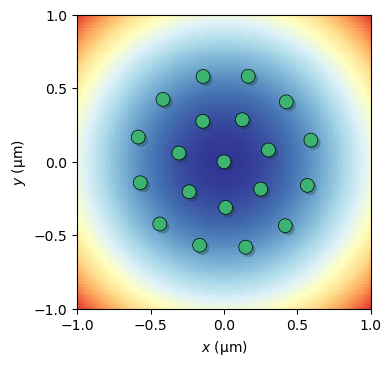

In [65]:
import matplotlib.animation as animation
from matplotlib import patheffects as pe

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
fm.plot_potential_energy(ax=ax, dxdy=(2, 2), print_voltages=False, plot_contours=False)

rx, ry = r2xy(r[:, -1])
pts_data = ax.plot(rx*1e6, ry*1e6, 'ok', mfc='mediumseagreen', mew=0.5, ms=10, path_effects=[pe.SimplePatchShadow(), pe.Normal()])

# Only things in the update function will get updated.
def update(frame):
    rx, ry = r2xy(r[:, frame])
    # Update the electron positions (green dots)
    pts_data[0].set_xdata(rx * 1e6)
    pts_data[0].set_ydata(ry * 1e6)

    return pts_data, 

fig.tight_layout()
# The interval is in milliseconds 
anim = animation.FuncAnimation(fig=fig, func=update, frames=np.arange(2, n_timesteps+2, 25), interval=30, repeat=True)

In [66]:
fm.show_animation(anim)

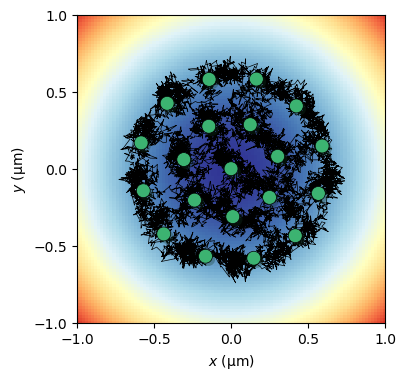

In [68]:
# n_electrons = 20

fig, ax = plt.subplots(1, 1, figsize=(4, 4))

fm = FullModel(potential_dict=potential_dict, voltage_dict=voltages)

fm.plot_potential_energy(ax=ax, dxdy=(2, 2), print_voltages=False, plot_contours=False)

for k in range(n_electrons):
    plt.plot(r[2*k, :] * 1e6, r[2*k+1, :] * 1e6, '-k', lw=.5)
    
fm.plot_electron_positions(res, ax=ax)

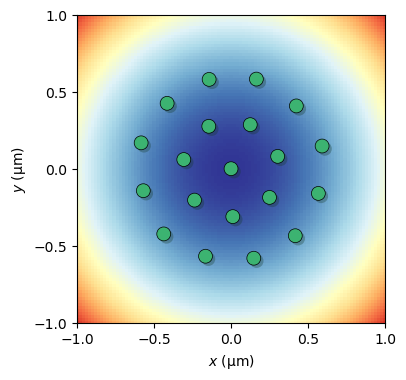

In [58]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

fm = FullModel(potential_dict=potential_dict, voltage_dict=voltages)

fm.plot_potential_energy(ax=ax, dxdy=(2, 2), print_voltages=False, plot_contours=False)

for k in range(n_electrons):
    plt.plot(r[2*k, :] * 1e6, r[2*k+1, :] * 1e6, '-k', lw=.5)
    
fm.plot_electron_positions(res, ax=ax)